Score the output of the CNN trained for multif0 + ismir 2015 contour classifier on the full mixes in the medleydb test set against the melody2 annotations

**This was not used in the end**

In [1]:
import motif
import motif.plot
import numpy as np
import mir_eval
import os
import medleydb as mdb
import seaborn
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Get Train/Test/Validation sets

In [2]:
with open("../outputs/data_splits.json", 'r') as fhandle:
    dat_dict = json.load(fhandle)

def get_file_pairs(track_id_list):
    file_pairs = []
    for track_id in track_id_list:
        mtrack = mdb.MultiTrack(track_id)
        if mtrack.dataset_version != 'V1':
            continue
        npy_path = "../comparisons/multif0/algorithm_outputs/experiment11b_output/fullmix_outputs/{}_prediction.npy".format(track_id)
        if os.path.exists(npy_path):
            file_pairs.append([npy_path, mtrack.mix_path, mtrack.melody2_fpath, track_id])
    return file_pairs

file_pairs_train = get_file_pairs(dat_dict['train'])
file_pairs_validate = get_file_pairs(dat_dict['validate'])
file_pairs_test = get_file_pairs(dat_dict['test'])

ftr_bitt = motif.feature_extractors.BitteliFeatures()

### Get train/test/validate contours, features and labels

In [3]:
def get_XY_pairs(etr, ftr, file_pairs):
    contour_list = {}
    features_list = []
    labels_list = []

    for npy_path, mix_path, annotation, track_id in file_pairs:
        print(track_id)
        ctr = etr.compute_contours(npy_path, mix_path)
        Y_train, _ = ctr.compute_labels(annotation)
        X_train = ftr.compute_all(ctr)

        features_list.append(X_train)
        labels_list.append(Y_train)
        contour_list[track_id] = ctr

    X = np.concatenate(features_list)
    Y = np.concatenate(labels_list)
    return X, Y, contour_list

In [5]:
etr_cnn = motif.contour_extractors.DeepSal()

X_train_cnn, Y_train_cnn, train_contours_cnn = \
    get_XY_pairs(etr_cnn, ftr_bitt, file_pairs_train)
X_validate_cnn, Y_validate_cnn, validate_contours_cnn = \
    get_XY_pairs(etr_cnn, ftr_bitt, file_pairs_validate)
X_test_cnn, Y_test_cnn, test_contours_cnn = \
    get_XY_pairs(etr_cnn, ftr_bitt, file_pairs_test)

AimeeNorwich_Child
AimeeNorwich_Flying
AlexanderRoss_GoodbyeBolero
AlexanderRoss_VelvetCurtain
AmarLal_Rest
AmarLal_SpringDay1
AvaLuna_Waterduct
BigTroubles_Phantom
ClaraBerryAndWooldog_AirTraffic
ClaraBerryAndWooldog_Boys
ClaraBerryAndWooldog_Stella
ClaraBerryAndWooldog_TheBadGuys
ClaraBerryAndWooldog_WaltzForMyVictims
CroqueMadame_Oil
CroqueMadame_Pilot
DreamersOfTheGhetto_HeavyLove
EthanHein_1930sSynthAndUprightBass
EthanHein_GirlOnABridge
FacesOnFilm_WaitingForGa
FamilyBand_Again
Handel_TornamiAVagheggiar
HeladoNegro_MitadDelMundo
HopAlong_SisterCities
InvisibleFamiliars_DisturbingWildlife
JoelHelander_Definition
JoelHelander_ExcessiveResistancetoChange
JoelHelander_IntheAtticBedroom
KarimDouaidy_Hopscotch
KarimDouaidy_Yatora
LizNelson_Coldwar
LizNelson_ImComingHome
LizNelson_Rainfall
Meaxic_TakeAStep
Meaxic_YouListen
MichaelKropf_AllGoodThings
Mozart_BesterJungling
MusicDelta_80sRock
MusicDelta_Beatles
MusicDelta_Beethoven
MusicDelta_Britpop
MusicDelta_ChineseChaoZhou
MusicDelta_C

In [7]:
X_validate_cnn, Y_validate_cnn, validate_contours_cnn = \
    get_XY_pairs(etr_cnn, ftr_bitt, file_pairs_validate)

BrandonWebster_DontHearAThing
BrandonWebster_YesSirICanFly
HezekiahJones_BorrowedHeart
MusicDelta_BebopJazz
MusicDelta_GriegTrolltog
MusicDelta_LatinJazz
MusicDelta_ModalJazz
SecretMountains_HighHorse
SweetLights_YouLetMeDown


### Train contour classifier

In [6]:
clf_cnn = motif.contour_classifiers.RandomForest()
clf_cnn.fit(X_train_cnn, Y_train_cnn)

### Compute classification scores

In [10]:
def score_classifier(clf, X, Y_true):
    Y_prob = clf.predict(X)
    Y_pred = (np.array(Y_prob >= clf.threshold)).astype(int)
    scores = clf.score(Y_pred, Y_true, y_prob=Y_prob)
    return scores

In [11]:
train_scores = score_classifier(clf_cnn, X_train_cnn, Y_train_cnn)
validate_scores = score_classifier(clf_cnn, X_validate_cnn, Y_validate_cnn)
test_scores = score_classifier(clf_cnn, X_test_cnn, Y_test_cnn)

print(train_scores)
print(validate_scores)
print(test_scores)

{'f1': array([ 0.99941231,  0.99192263]), 'recall': array([ 0.99883329,  0.99988922]), 'support': array([125138,   9027]), 'mcc': 0.99137119325743184, 'precision': array([ 0.999992  ,  0.98408199]), 'auc score': 0.9999976824079625, 'confusion matrix': array([[124992,    146],
       [     1,   9026]]), 'accuracy': 0.99890433421533187}
{'f1': array([ 0.97328667,  0.55238095]), 'recall': array([ 0.97319933,  0.55321285]), 'support': array([16716,   996]), 'mcc': 0.52566835105896592, 'precision': array([ 0.97337402,  0.55155155]), 'auc score': 0.88733304238730459, 'confusion matrix': array([[16268,   448],
       [  445,   551]]), 'accuracy': 0.94958220415537486}
{'f1': array([ 0.96866983,  0.53963902]), 'recall': array([ 0.97879026,  0.46846489]), 'support': array([63650,  5042]), 'mcc': 0.51589597722518488, 'precision': array([ 0.95875654,  0.63631466]), 'auc score': 0.8992463604231915, 'confusion matrix': array([[62300,  1350],
       [ 2680,  2362]]), 'accuracy': 0.94133232399697198}


### Get contour melody probabilities

In [12]:
def get_contour_melprobs(ftr, clf, contours_dict):
    scores = {}

    for trackid, ctr in contours_dict.items():
        print(trackid)
        X = ftr.compute_all(ctr)
        Y = clf.predict(X)
        scores[trackid] = Y

    return scores

In [13]:
validation_melprobs = get_contour_melprobs(
    ftr_bitt, clf_cnn, validate_contours_cnn
)
test_melprobs = get_contour_melprobs(
    ftr_bitt, clf_cnn, test_contours_cnn
)

MusicDelta_LatinJazz
MusicDelta_GriegTrolltog
SweetLights_YouLetMeDown
BrandonWebster_YesSirICanFly
SecretMountains_HighHorse
HezekiahJones_BorrowedHeart
MusicDelta_BebopJazz
BrandonWebster_DontHearAThing
MusicDelta_ModalJazz
Phoenix_SeanCaughlinsTheScartaglen
Schubert_Erstarrung
Phoenix_ColliersDaughter
AClassicEducation_NightOwl
Phoenix_LarkOnTheStrandDrummondCastle
ChrisJacoby_PigsFoot
Mozart_DiesBildnis
MatthewEntwistle_TheArch
Auctioneer_OurFutureFaces
MatthewEntwistle_DontYouEver
PortStWillow_StayEven
MusicDelta_FusionJazz
Phoenix_BrokenPledgeChicagoReel
MatthewEntwistle_FairerHopes
Debussy_LenfantProdigue
Creepoid_OldTree
MusicDelta_SwingJazz
MatthewEntwistle_Lontano
CelestialShore_DieForUs
MusicDelta_Pachelbel
ChrisJacoby_BoothShotLincoln
StrandOfOaks_Spacestation
Phoenix_ElzicsFarewell
MusicDelta_Gospel
MatthewEntwistle_ImpressionsOfSaturn
MatthewEntwistle_TheFlaxenField
Phoenix_ScotchMorris


### Get best probability threshold

In [36]:
reload(motif)
reload(motif.contour_decoders)
reload(motif.contour_decoders.maximum)

<module 'motif.contour_decoders.maximum' from '/Users/rabitt/Dropbox/MARL/repos/motif/motif/contour_decoders/maximum.pyc'>

In [37]:
dcd = motif.contour_decoders.MaxDecoder()
dcd.dummy()

derp derp derp


In [38]:
thresh_vals = np.arange(0, 0.4, 0.01)
mel_accuracy = {v: [] for v in thresh_vals}

for trackid in validate_contours_cnn.keys():
    print(trackid)
    mtrack = mdb.MultiTrack(trackid)

    ctr = validate_contours_cnn[trackid]
    scores = validation_melprobs[trackid]    
    
    mel2 = mtrack.melody2_annotation
    mel2 = np.array(mel2).T
    ref_times, ref_freqs = (mel2[0], mel2[1])

    for thresh in thresh_vals:
        dcd = motif.contour_decoders.MaxDecoder(thresh=thresh)
        est_times, est_freqs = dcd.decode(ctr, scores)

        mel_scores = mir_eval.melody.evaluate(ref_times, ref_freqs, est_times, est_freqs)
        mel_accuracy[thresh].append(mel_scores['Overall Accuracy'])

MusicDelta_LatinJazz
MusicDelta_GriegTrolltog
SweetLights_YouLetMeDown
BrandonWebster_YesSirICanFly
SecretMountains_HighHorse
HezekiahJones_BorrowedHeart
MusicDelta_BebopJazz
BrandonWebster_DontHearAThing
MusicDelta_ModalJazz


In [39]:
accuracy_vals = [np.mean(mel_accuracy[thresh]) for thresh in thresh_vals]
best_thresh_idx = np.argmax(accuracy_vals)
best_thresh = thresh_vals[best_thresh_idx]

print("Best threshold is {} with an OA of {}".format(
    best_thresh, accuracy_vals[best_thresh_idx])
)

Best threshold is 0.39 with an OA of 0.410840039111


### Score Melody Outputs on Test Set

Phoenix_SeanCaughlinsTheScartaglen


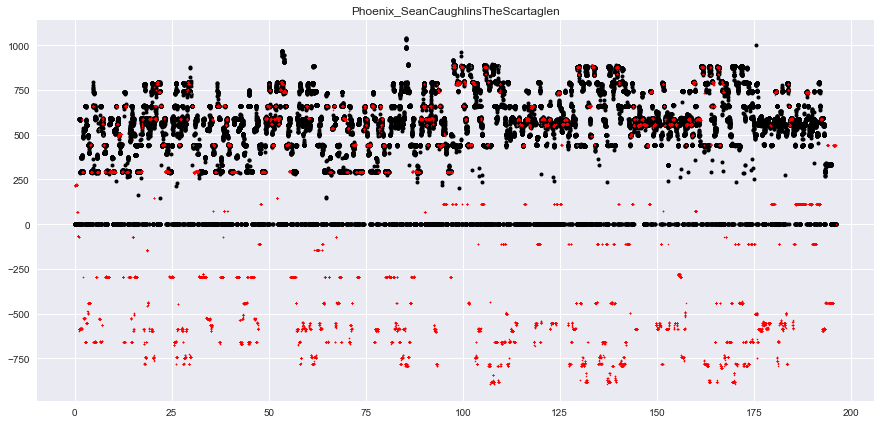

Schubert_Erstarrung


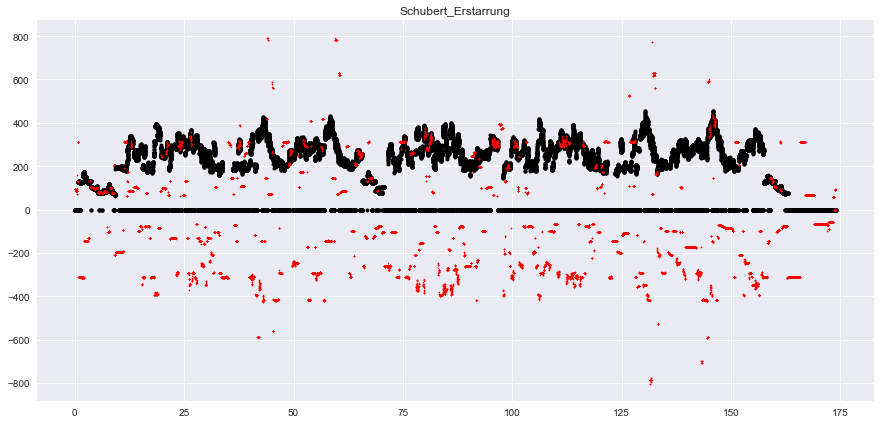

Phoenix_ColliersDaughter


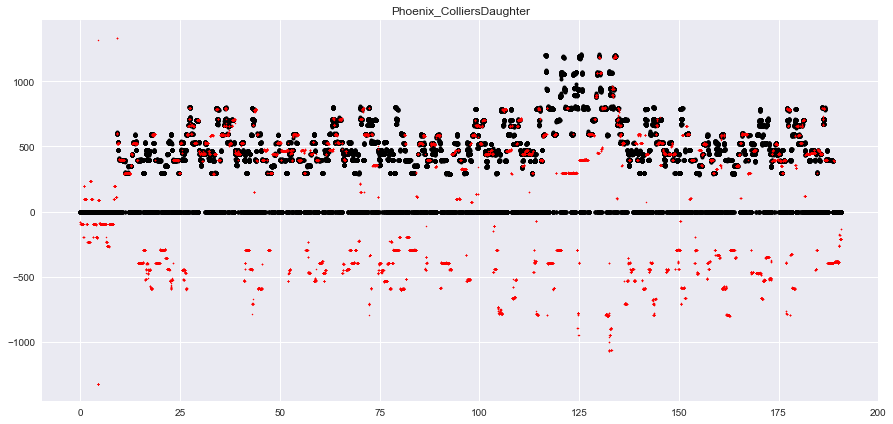

AClassicEducation_NightOwl


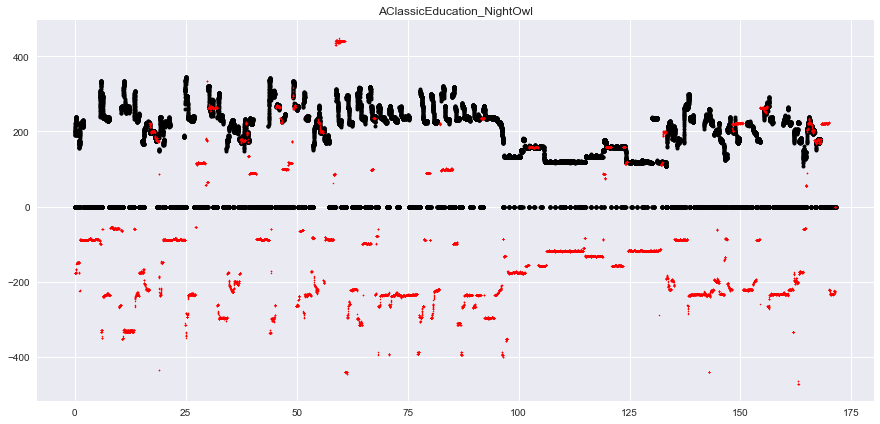

Phoenix_LarkOnTheStrandDrummondCastle


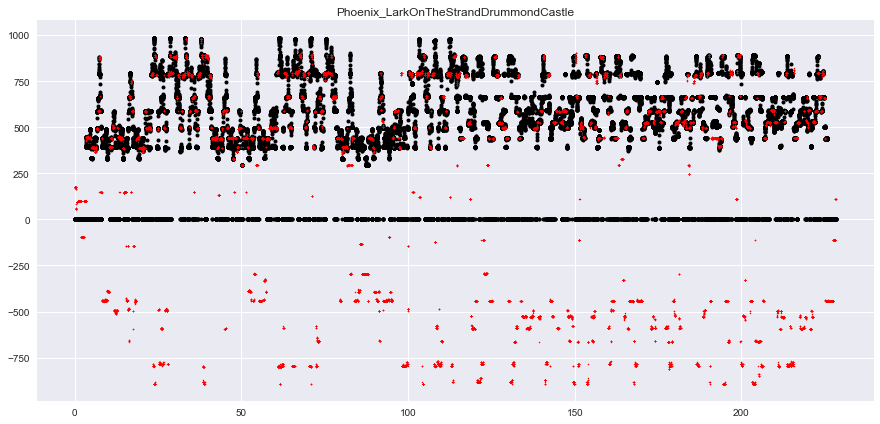

ChrisJacoby_PigsFoot


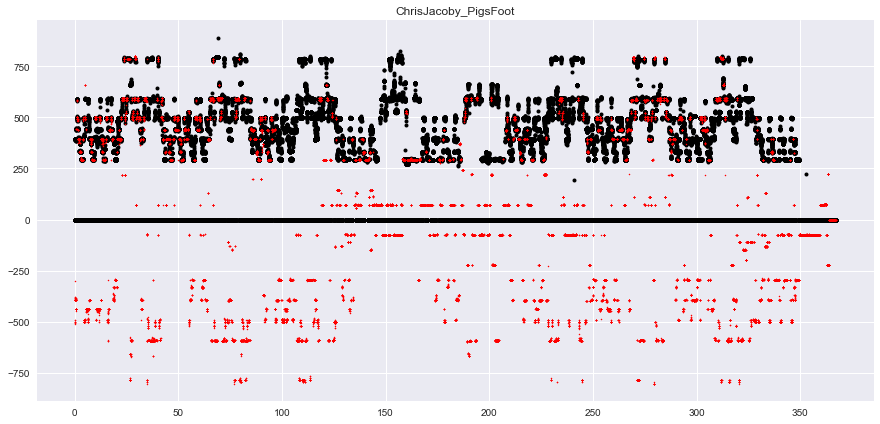

Mozart_DiesBildnis


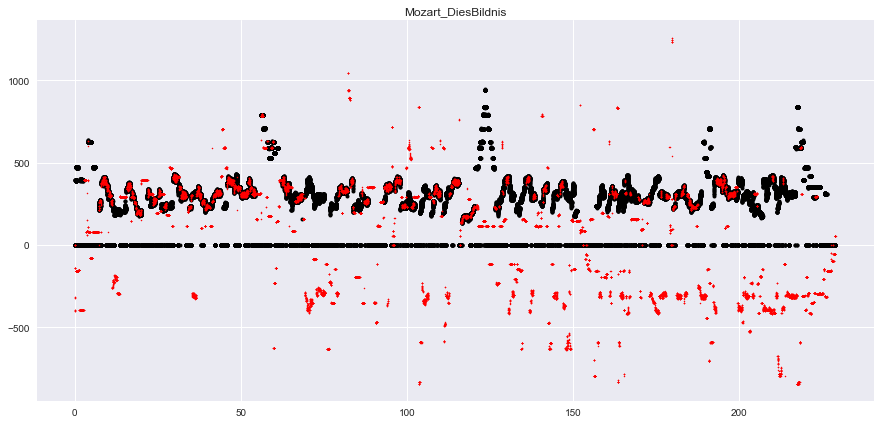

MatthewEntwistle_TheArch


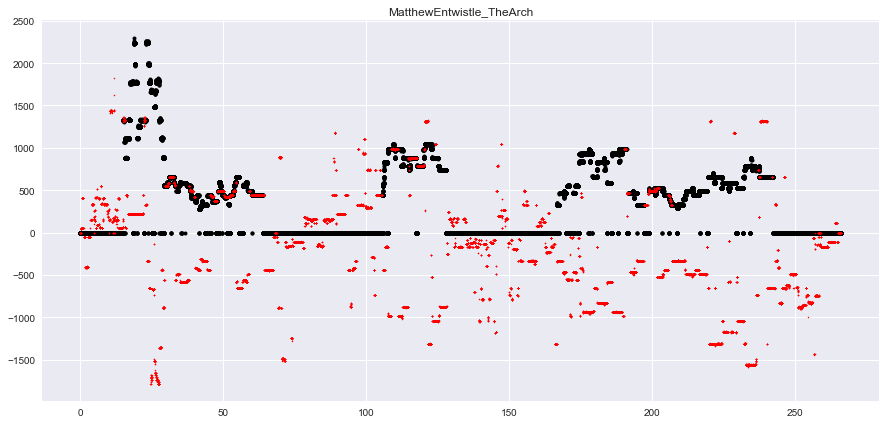

Auctioneer_OurFutureFaces


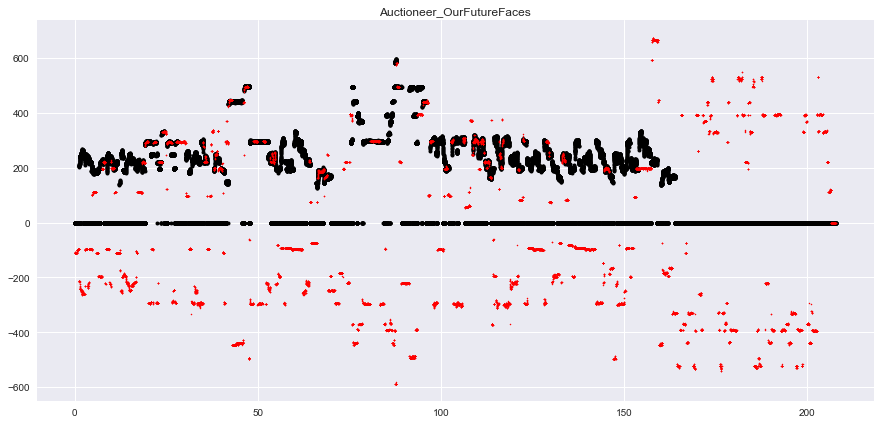

MatthewEntwistle_DontYouEver


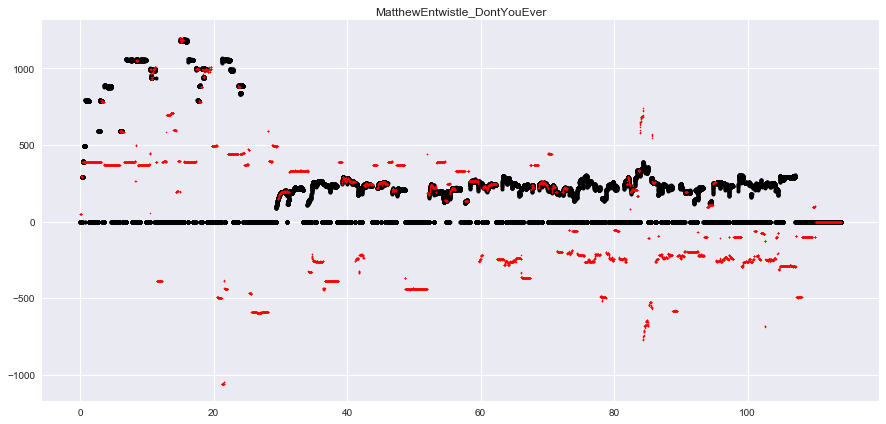

PortStWillow_StayEven


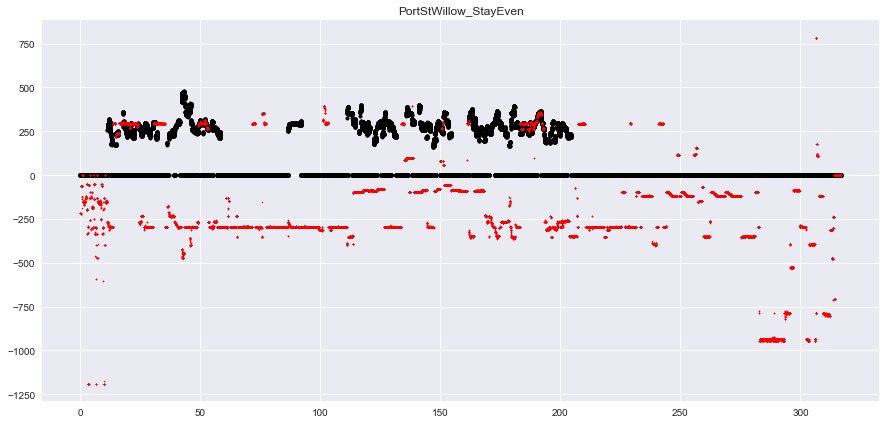

MusicDelta_FusionJazz


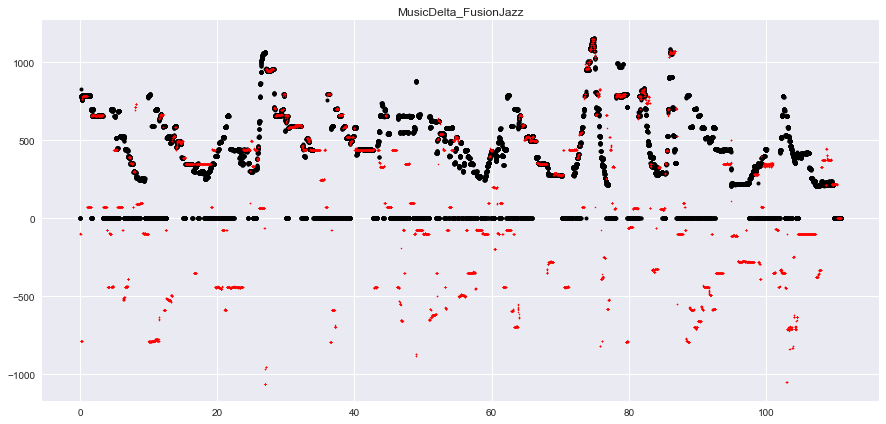

Phoenix_BrokenPledgeChicagoReel


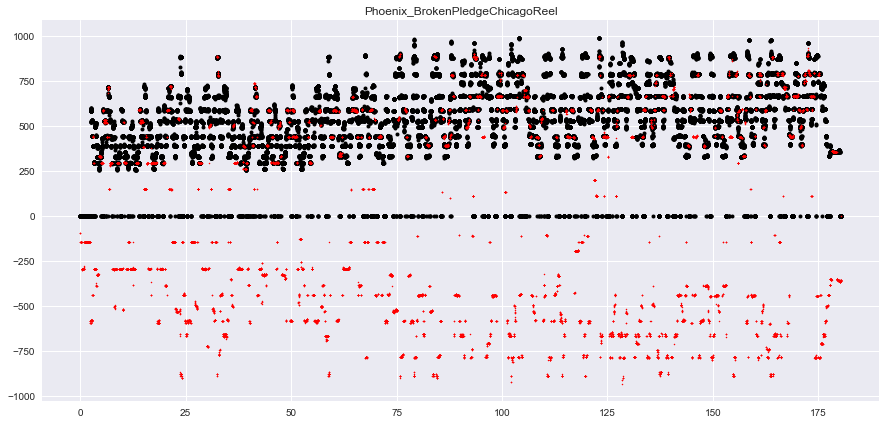

MatthewEntwistle_FairerHopes


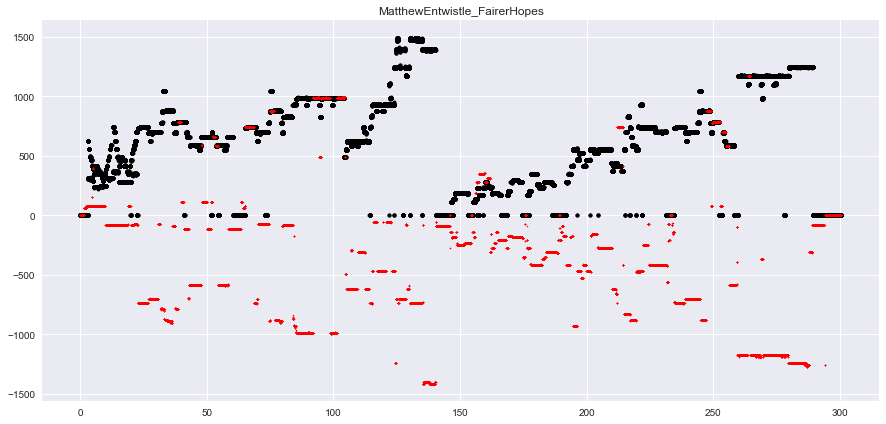

Debussy_LenfantProdigue


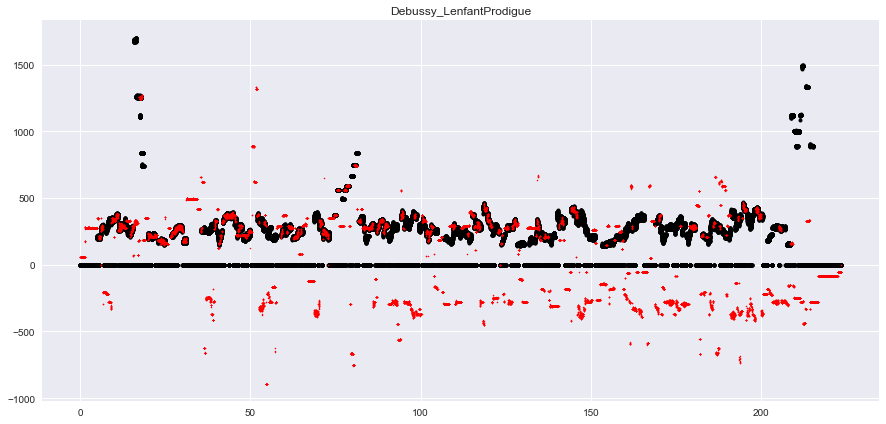

Creepoid_OldTree


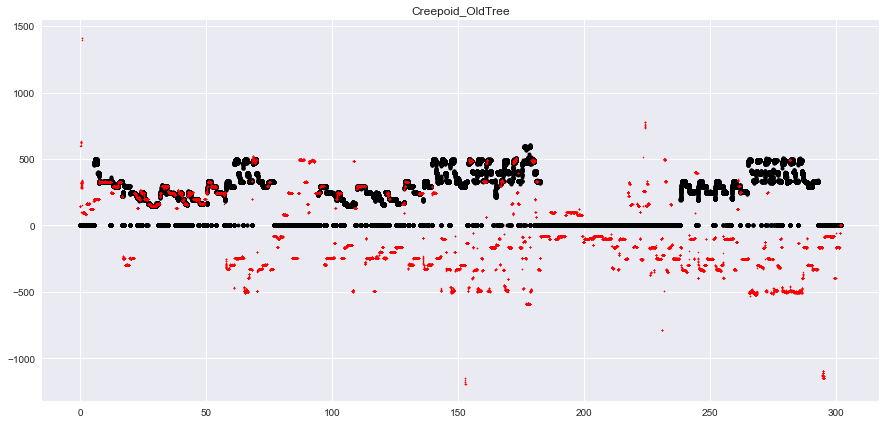

MusicDelta_SwingJazz


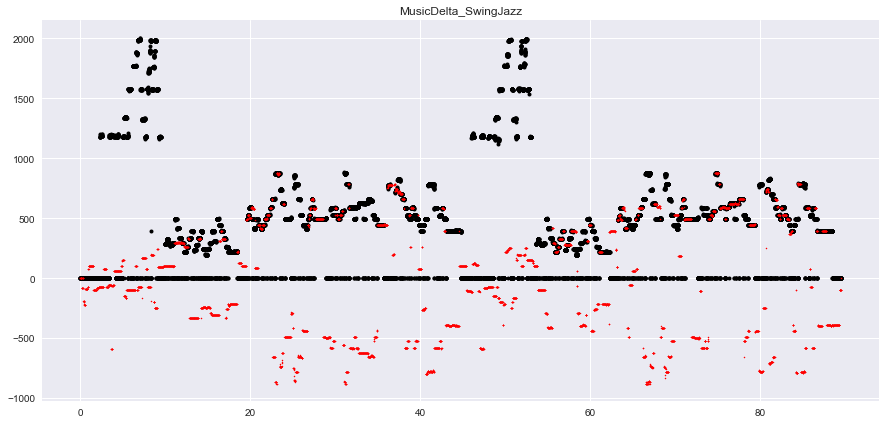

MatthewEntwistle_Lontano


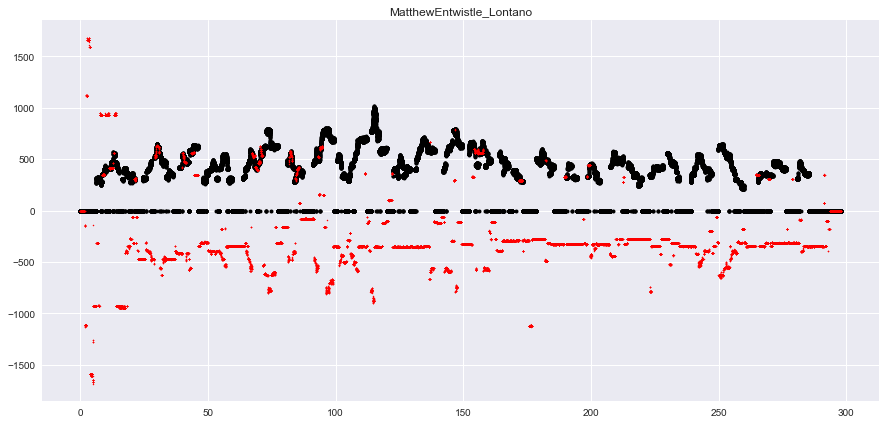

CelestialShore_DieForUs


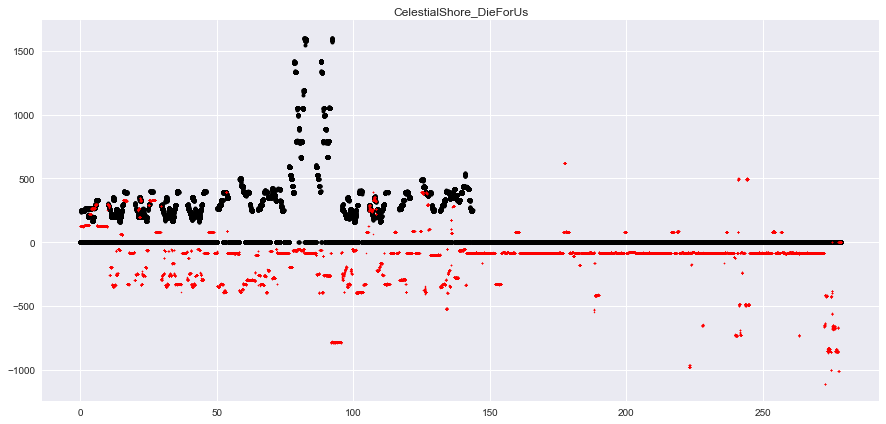

MusicDelta_Pachelbel


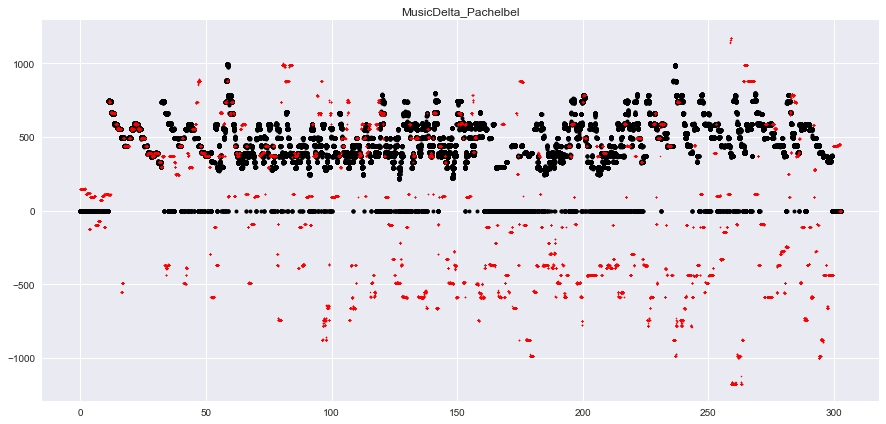

ChrisJacoby_BoothShotLincoln


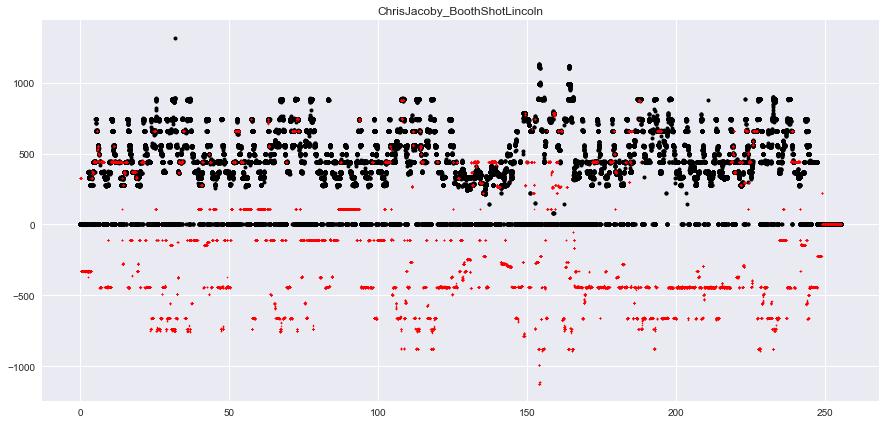

StrandOfOaks_Spacestation


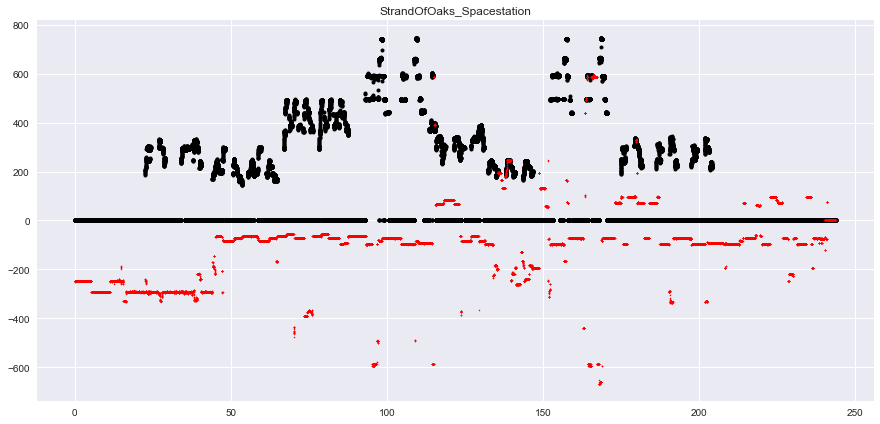

Phoenix_ElzicsFarewell


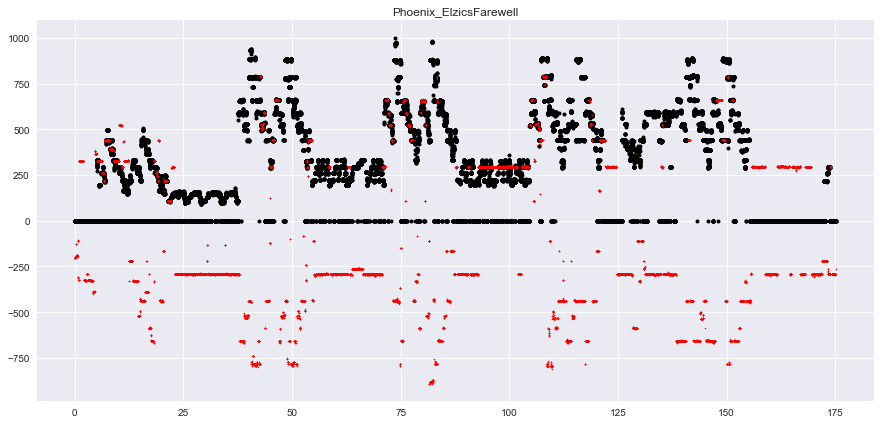

MusicDelta_Gospel


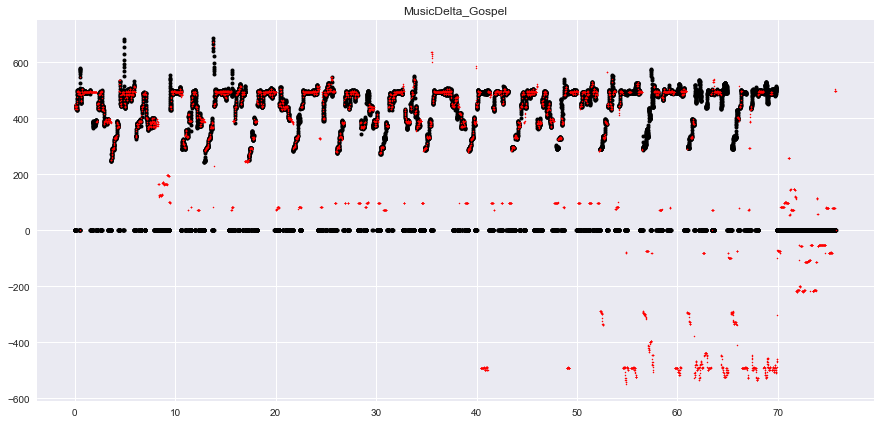

MatthewEntwistle_ImpressionsOfSaturn


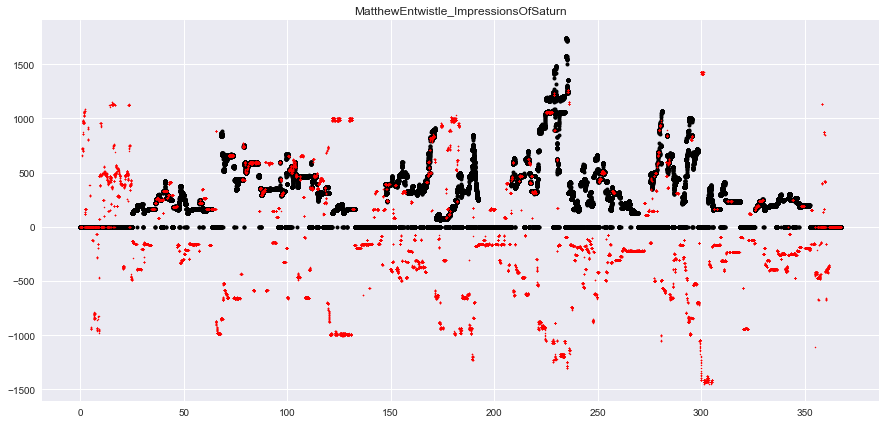

MatthewEntwistle_TheFlaxenField


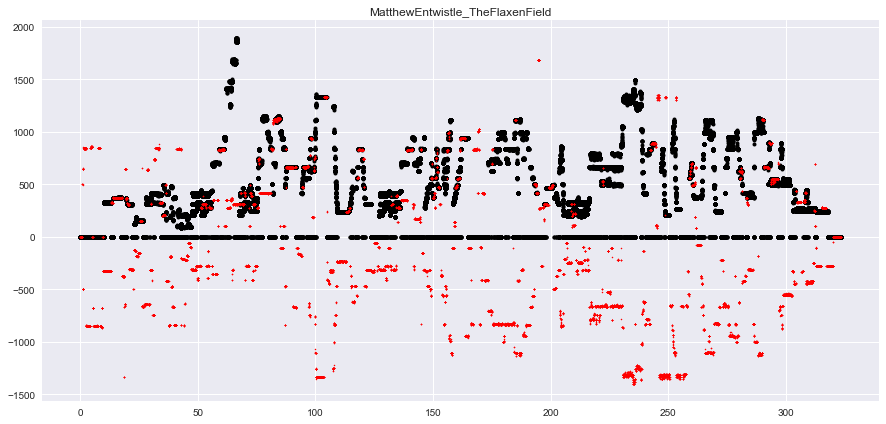

Phoenix_ScotchMorris


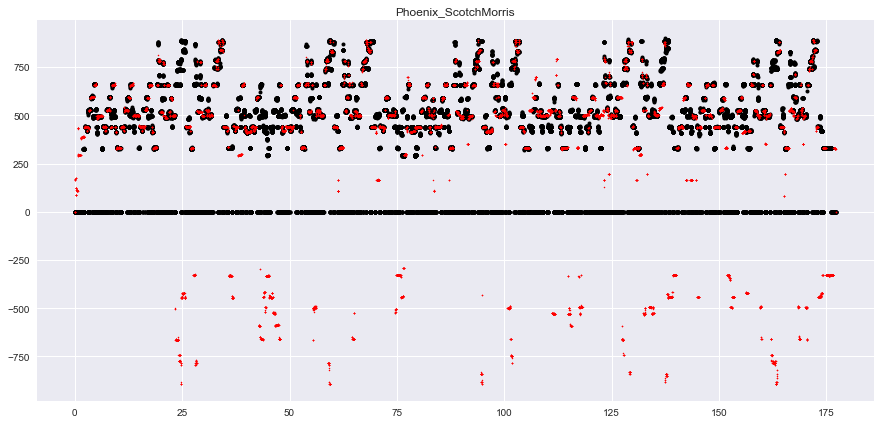

In [46]:
dcd = motif.contour_decoders.MaxDecoder(thresh=best_thresh)

all_mel_scores = []
for trackid in test_contours_cnn.keys():
    print(trackid)
    mtrack = mdb.MultiTrack(trackid)
    
    ctr = test_contours_cnn[trackid]
    scores = test_melprobs[trackid]

    mel2 = mtrack.melody2_annotation
    mel2 = np.array(mel2).T
    ref_times, ref_freqs = (mel2[0], mel2[1])
    est_times, est_freqs = dcd.decode(ctr, scores)

    plt.figure(figsize=(15, 7))
    plt.title(trackid)
    plt.plot(ref_times, ref_freqs, '.k', markersize=8)
    plt.plot(est_times, est_freqs, '.r', markersize=3)
    plt.show()

    mel_scores = mir_eval.melody.evaluate(ref_times, ref_freqs, est_times, est_freqs)
    all_mel_scores.append(mel_scores)

mel_scores_df = pd.DataFrame(all_mel_scores)
mel_scores_df.to_csv("../outputs/CNN_contourclf_mel2_scores.csv")

In [47]:
mel_scores_df.describe()

,Overall Accuracy,Raw Chroma Accuracy,Raw Pitch Accuracy,Voicing False Alarm,Voicing Recall
count,27.000000,27.000000,27.000000,27.000000,27.000000
mean,0.373044,0.546234,0.484925,0.408689,0.429438
std,0.120123,0.142778,0.150475,0.193497,0.191122
min,0.209720,0.265744,0.191099,0.080985,0.129394
25%,0.320653,0.472046,0.386249,0.292627,0.297967
50%,0.362830,0.563472,0.506572,0.407180,0.394512
75%,0.399287,0.644732,0.562587,0.493339,0.559235
max,0.658018,0.904544,0.902261,0.846761,0.831468


### Get scores for partial mixes

In [48]:
track_id_list = dat_dict['test']
file_pairs_test_partial = []
for track_id in track_id_list:
    mtrack = mdb.MultiTrack(track_id)
    if mtrack.dataset_version != 'V1':
        continue
    npy_path = "../comparisons/multif0/algorithm_outputs/experiment11b_output/{}_prediction.npy".format(track_id)
    if os.path.exists(npy_path) and os.path.exists(mtrack.melody2_fpath):
        file_pairs_test_partial.append([npy_path, mtrack.mix_path, mtrack.melody2_fpath, track_id])

In [49]:
X_test_cnn_partial, Y_test_cnn_partial, test_contours_cnn_partial = \
    get_XY_pairs(etr_cnn, ftr_bitt, file_pairs_test_partial)

AClassicEducation_NightOwl
Auctioneer_OurFutureFaces
CelestialShore_DieForUs
ChrisJacoby_BoothShotLincoln
ChrisJacoby_PigsFoot
Creepoid_OldTree
Debussy_LenfantProdigue
MatthewEntwistle_DontYouEver
MatthewEntwistle_FairerHopes
MatthewEntwistle_ImpressionsOfSaturn
MatthewEntwistle_Lontano
MatthewEntwistle_TheArch
MatthewEntwistle_TheFlaxenField
Mozart_DiesBildnis
MusicDelta_FusionJazz
MusicDelta_Gospel
MusicDelta_Pachelbel
MusicDelta_SwingJazz
Phoenix_BrokenPledgeChicagoReel
Phoenix_ColliersDaughter
Phoenix_ElzicsFarewell
Phoenix_LarkOnTheStrandDrummondCastle
Phoenix_ScotchMorris
Phoenix_SeanCaughlinsTheScartaglen
PortStWillow_StayEven
Schubert_Erstarrung
StrandOfOaks_Spacestation


In [51]:
test_melprobs_partial = get_contour_melprobs(
    ftr_bitt, clf_cnn, test_contours_cnn_partial
)

Phoenix_SeanCaughlinsTheScartaglen
Schubert_Erstarrung
Phoenix_ColliersDaughter
AClassicEducation_NightOwl
Phoenix_LarkOnTheStrandDrummondCastle
ChrisJacoby_PigsFoot
Mozart_DiesBildnis
MatthewEntwistle_TheArch
Auctioneer_OurFutureFaces
MatthewEntwistle_DontYouEver
PortStWillow_StayEven
MusicDelta_FusionJazz
Phoenix_BrokenPledgeChicagoReel
MatthewEntwistle_FairerHopes
Debussy_LenfantProdigue
Creepoid_OldTree
MusicDelta_SwingJazz
MatthewEntwistle_Lontano
CelestialShore_DieForUs
MusicDelta_Pachelbel
ChrisJacoby_BoothShotLincoln
StrandOfOaks_Spacestation
Phoenix_ElzicsFarewell
MusicDelta_Gospel
MatthewEntwistle_ImpressionsOfSaturn
MatthewEntwistle_TheFlaxenField
Phoenix_ScotchMorris


Phoenix_SeanCaughlinsTheScartaglen


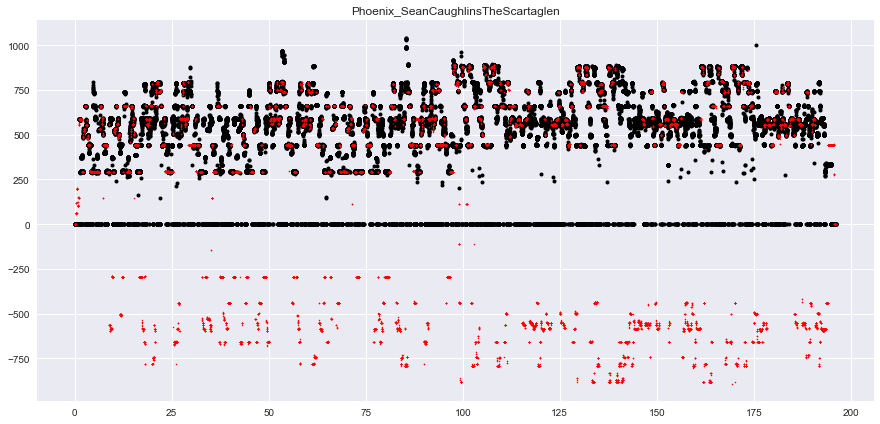

Schubert_Erstarrung


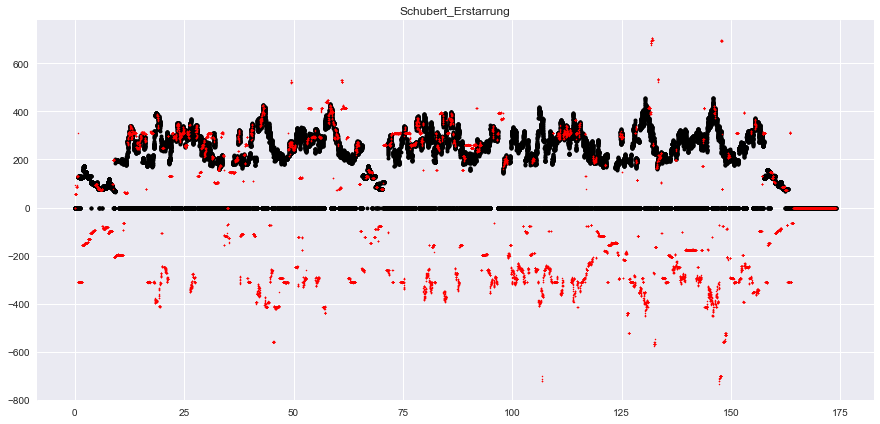

Phoenix_ColliersDaughter


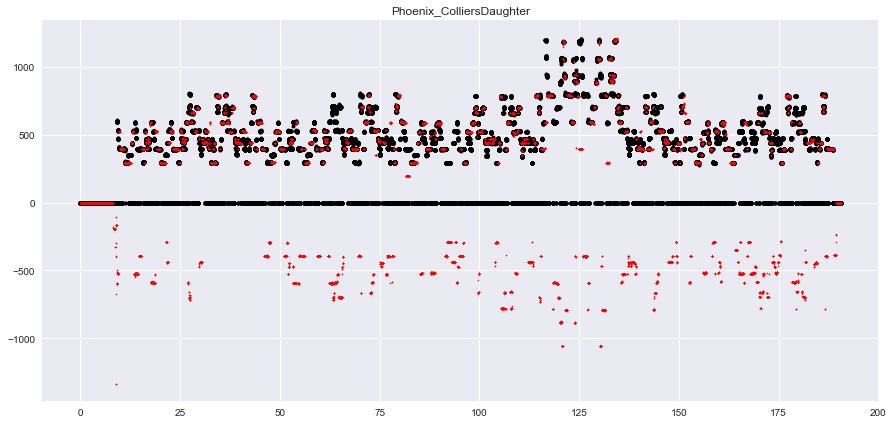

AClassicEducation_NightOwl


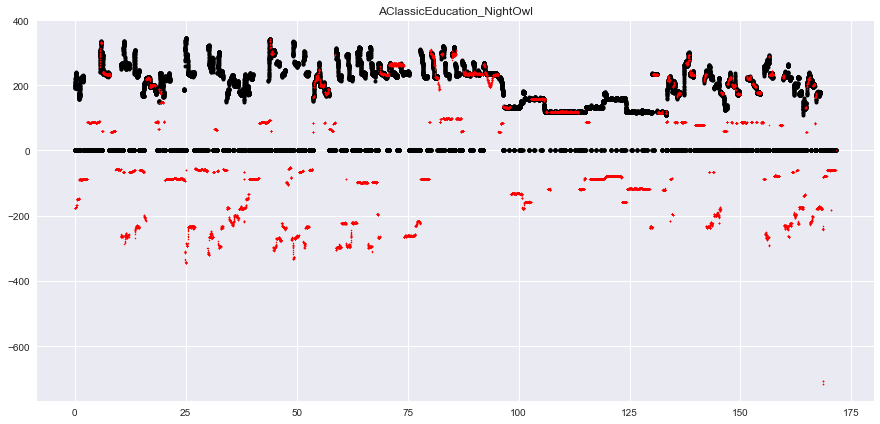

Phoenix_LarkOnTheStrandDrummondCastle


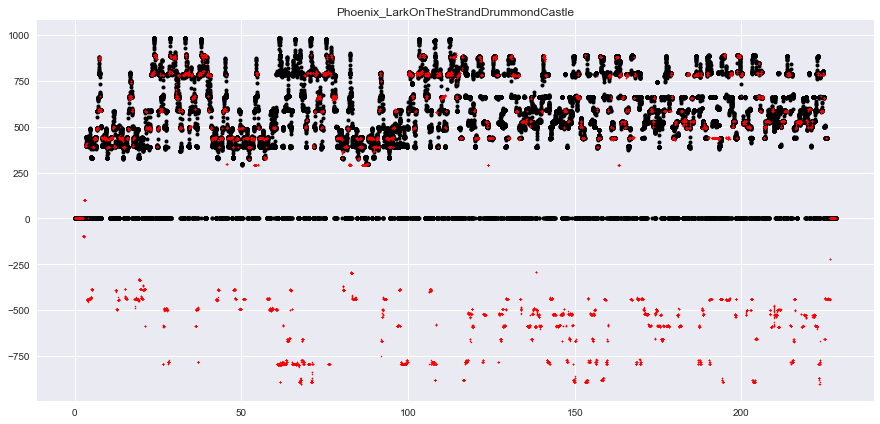

ChrisJacoby_PigsFoot


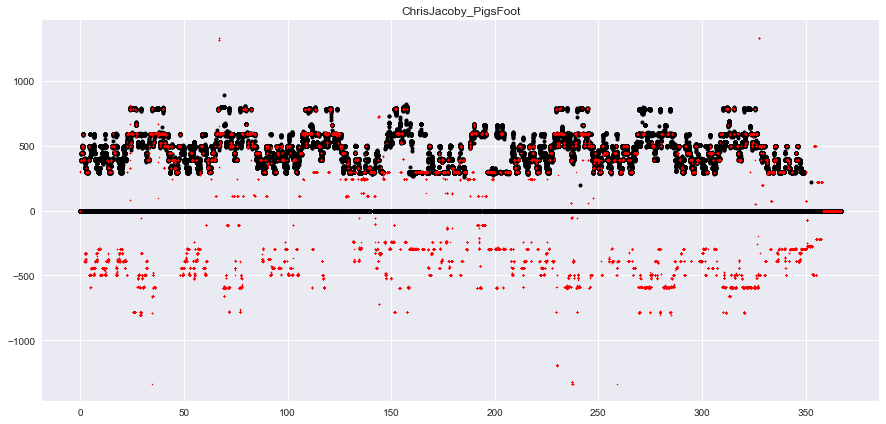

Mozart_DiesBildnis


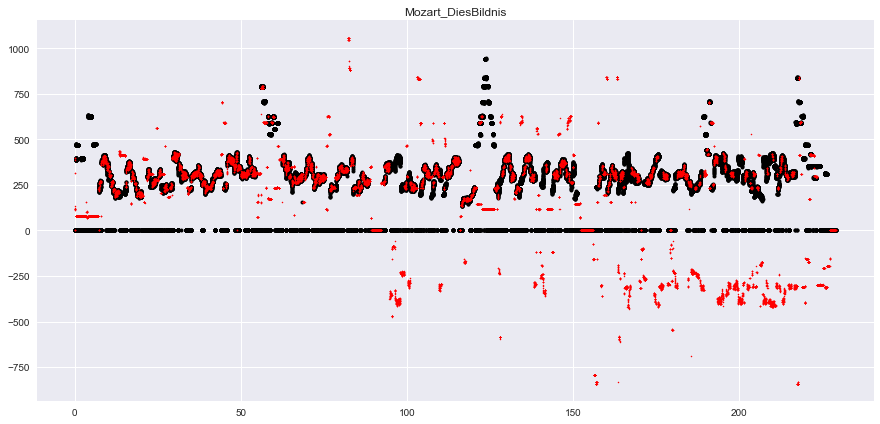

MatthewEntwistle_TheArch


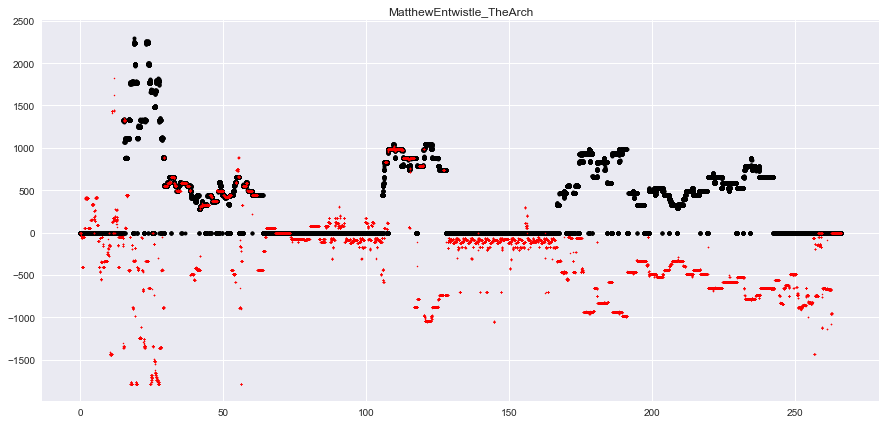

Auctioneer_OurFutureFaces


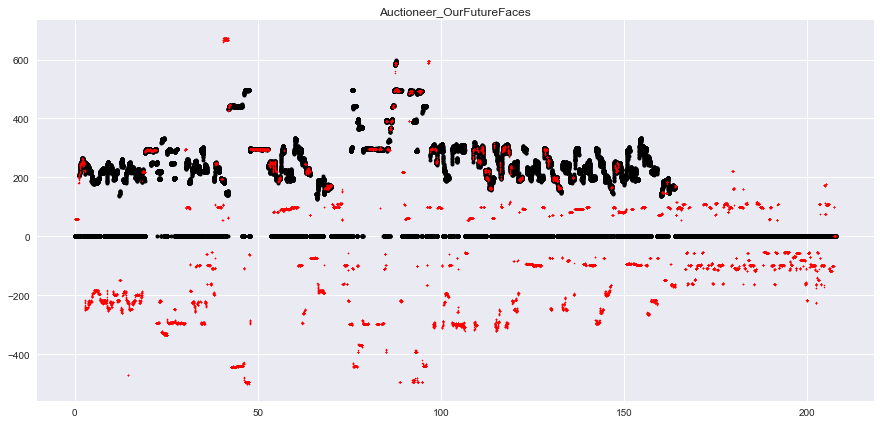

MatthewEntwistle_DontYouEver


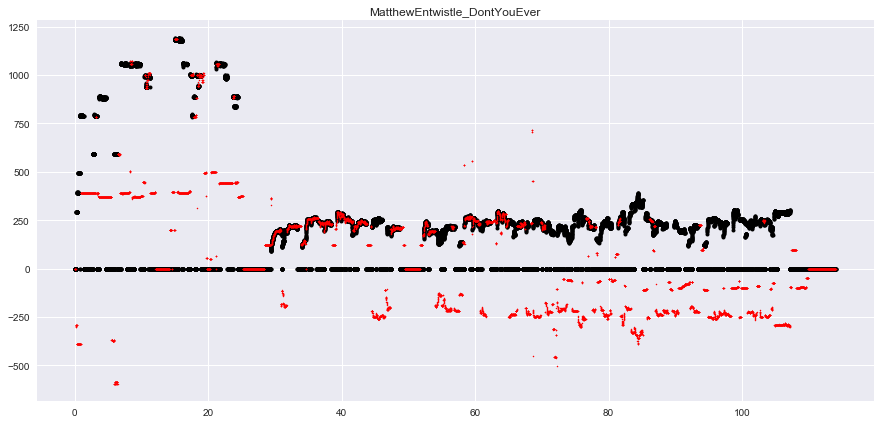

PortStWillow_StayEven


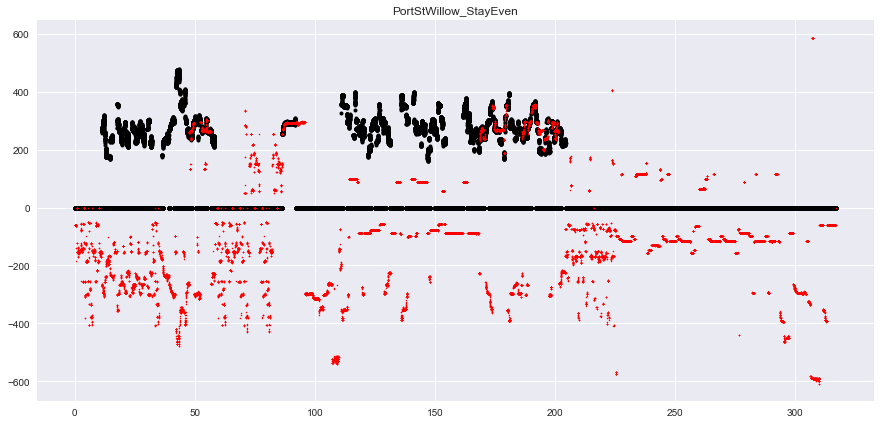

MusicDelta_FusionJazz


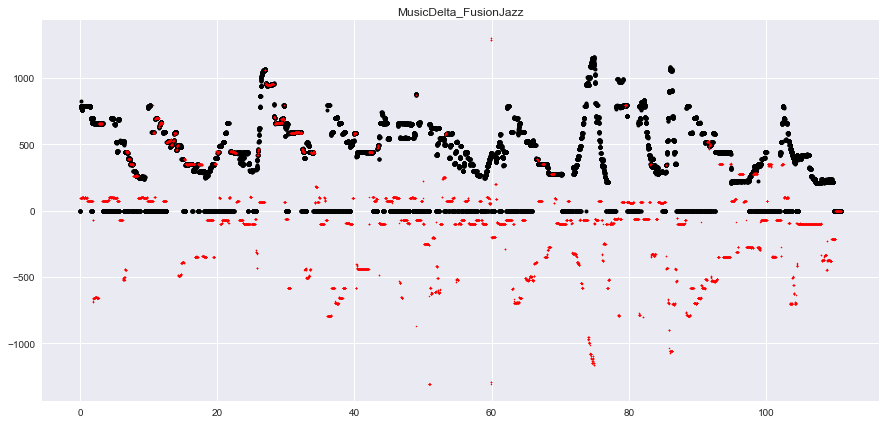

Phoenix_BrokenPledgeChicagoReel


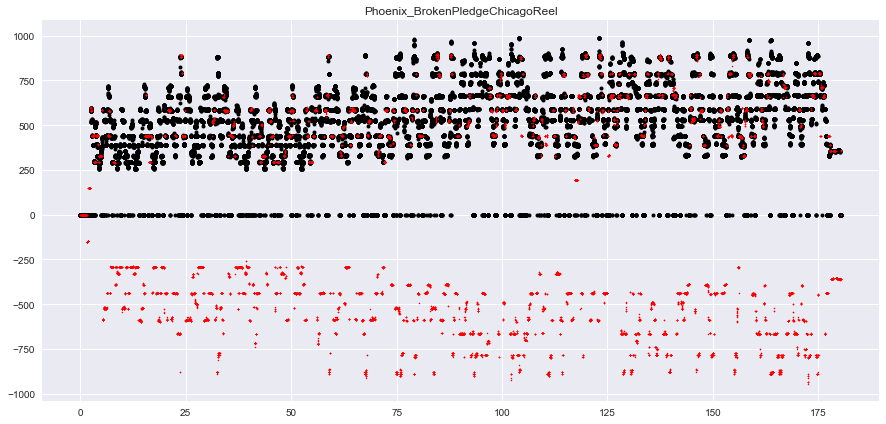

MatthewEntwistle_FairerHopes


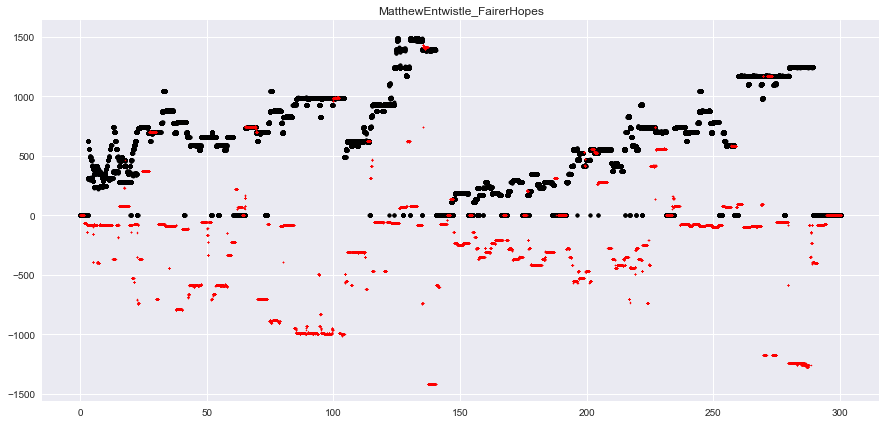

Debussy_LenfantProdigue


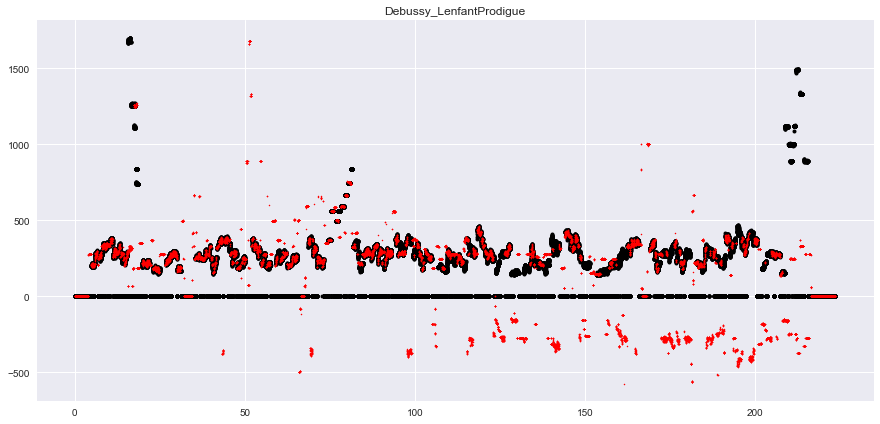

Creepoid_OldTree


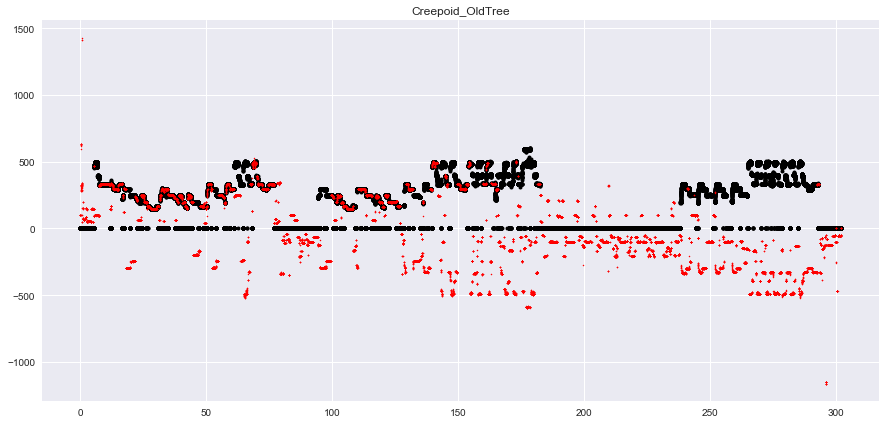

MusicDelta_SwingJazz


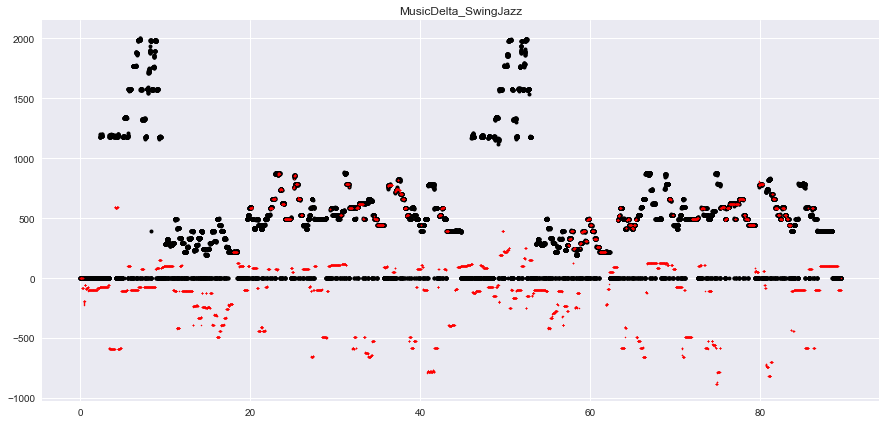

MatthewEntwistle_Lontano


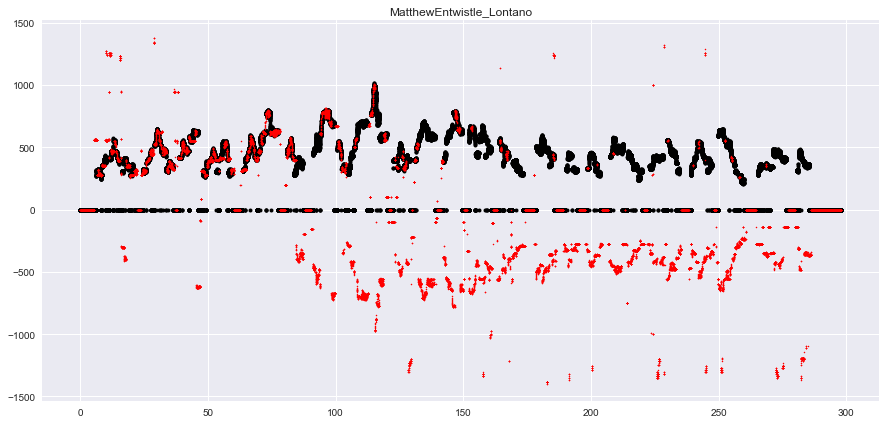

CelestialShore_DieForUs


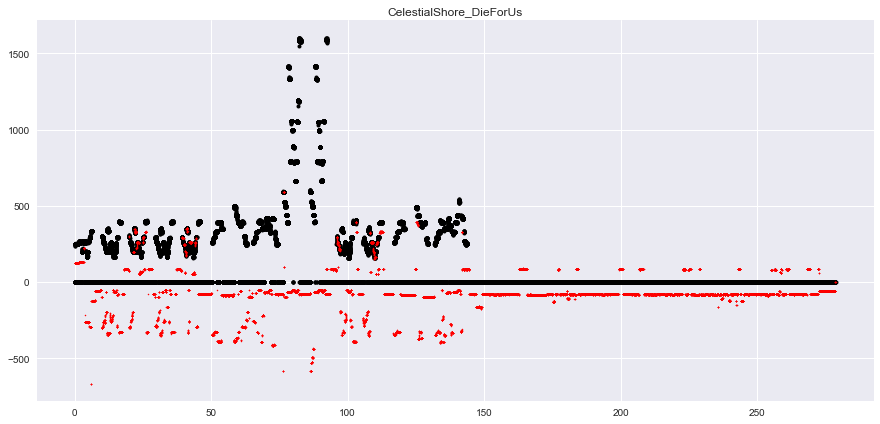

MusicDelta_Pachelbel


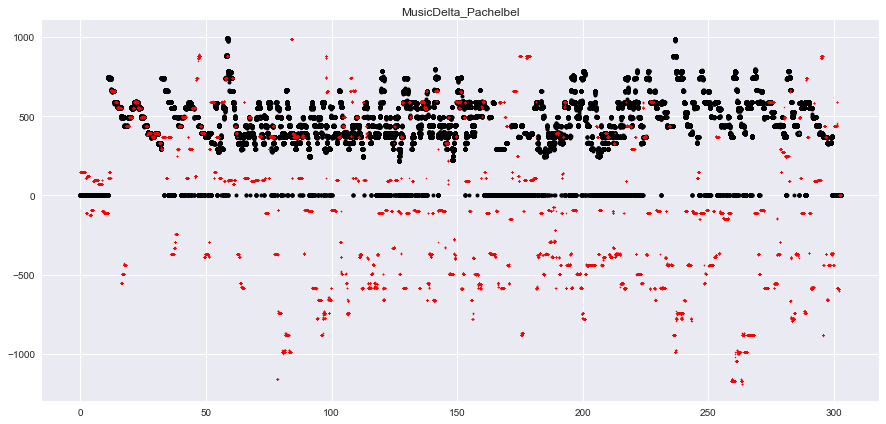

ChrisJacoby_BoothShotLincoln


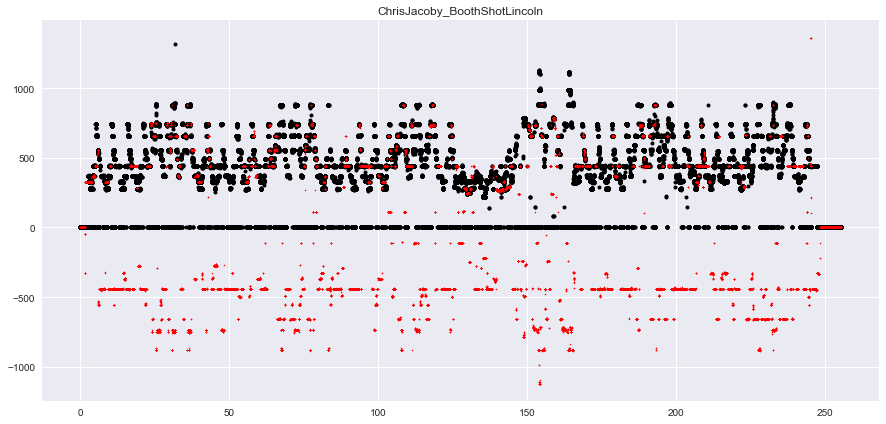

StrandOfOaks_Spacestation


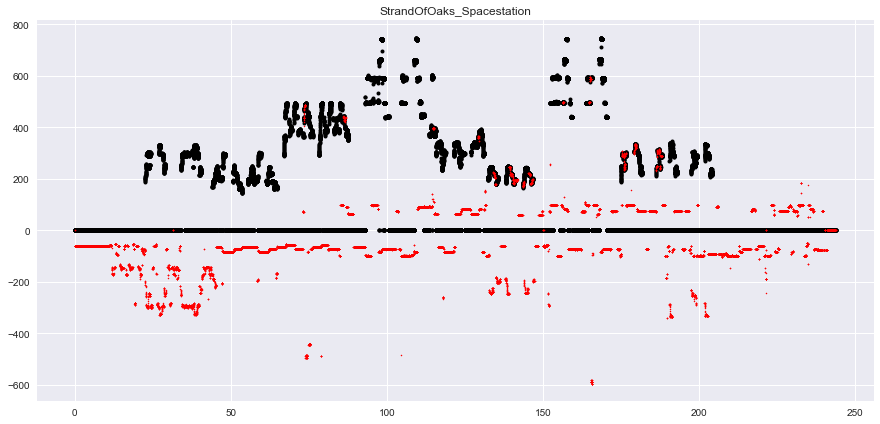

Phoenix_ElzicsFarewell


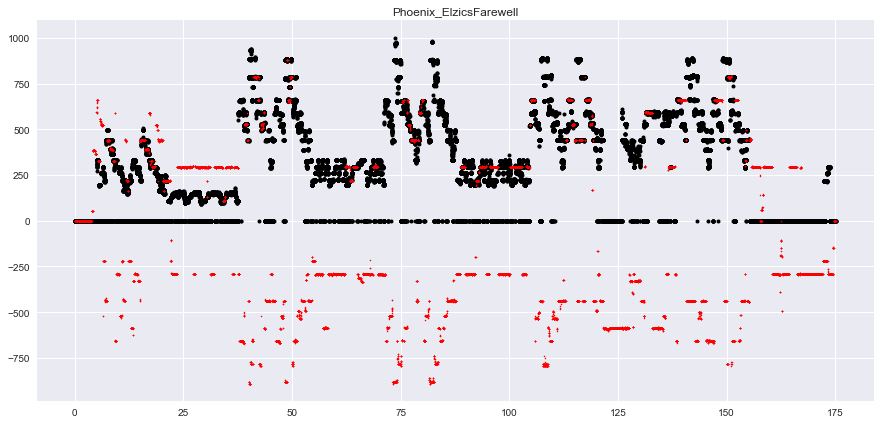

MusicDelta_Gospel


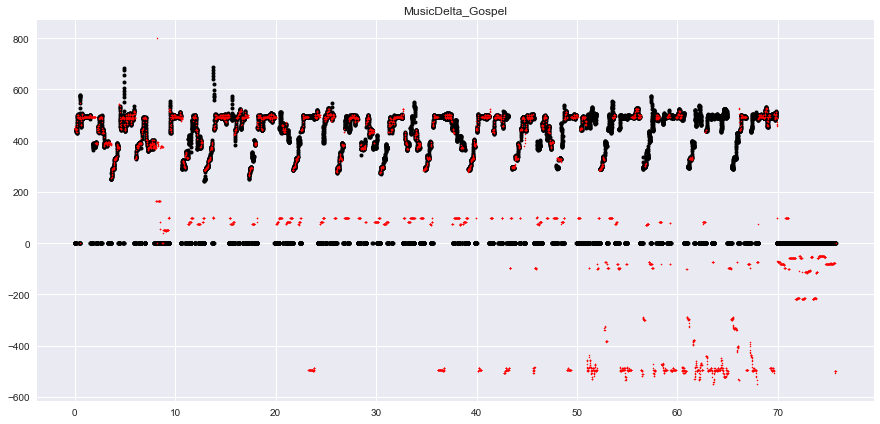

MatthewEntwistle_ImpressionsOfSaturn


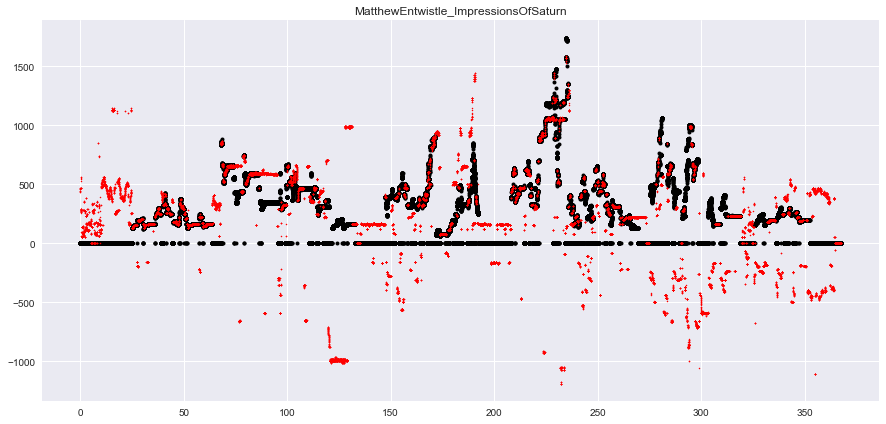

MatthewEntwistle_TheFlaxenField


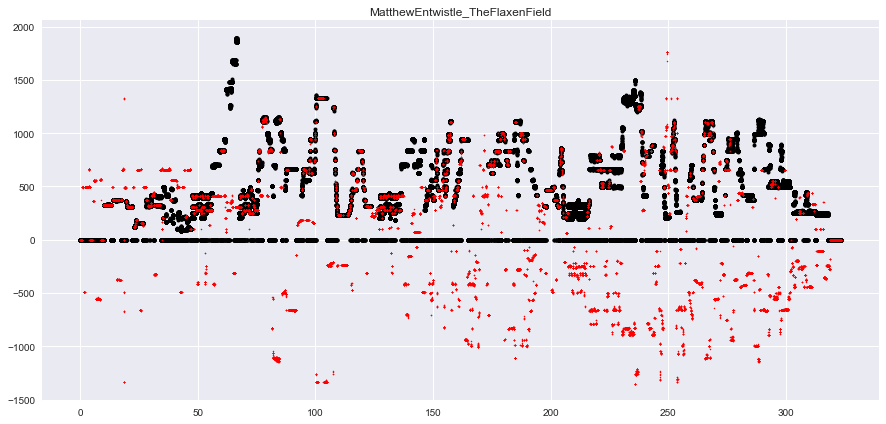

Phoenix_ScotchMorris


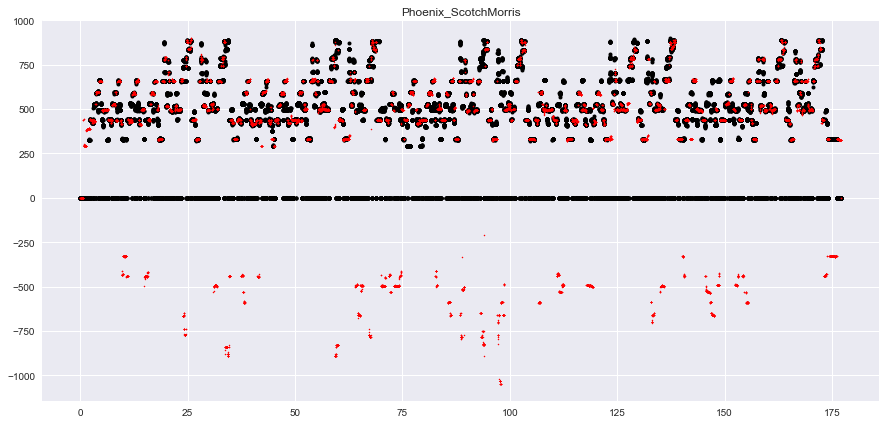

In [52]:
dcd = motif.contour_decoders.MaxDecoder(thresh=best_thresh)

all_mel_scores = []
for trackid in test_contours_cnn_partial.keys():
    print(trackid)
    mtrack = mdb.MultiTrack(trackid)
    
    ctr = test_contours_cnn_partial[trackid]
    scores = test_melprobs_partial[trackid]

    mel2 = mtrack.melody2_annotation
    mel2 = np.array(mel2).T
    ref_times, ref_freqs = (mel2[0], mel2[1])
    est_times, est_freqs = dcd.decode(ctr, scores)

    plt.figure(figsize=(15, 7))
    plt.title(trackid)
    plt.plot(ref_times, ref_freqs, '.k', markersize=8)
    plt.plot(est_times, est_freqs, '.r', markersize=3)
    plt.show()

    mel_scores = mir_eval.melody.evaluate(ref_times, ref_freqs, est_times, est_freqs)
    all_mel_scores.append(mel_scores)

mel_scores_df_partial = pd.DataFrame(all_mel_scores)
mel_scores_df_partial.to_csv("../outputs/CNN_contourclf_mel2_scores_partial.csv")

In [53]:
mel_scores_df_partial.describe()

,Overall Accuracy,Raw Chroma Accuracy,Raw Pitch Accuracy,Voicing False Alarm,Voicing Recall
count,27.000000,27.000000,27.000000,27.000000,27.000000
mean,0.409971,0.605279,0.560679,0.437365,0.507941
std,0.121856,0.141921,0.164436,0.184005,0.174499
min,0.177761,0.335105,0.236455,0.157119,0.207632
25%,0.346969,0.483735,0.447339,0.328523,0.392876
50%,0.424591,0.645697,0.609820,0.416936,0.481434
75%,0.489204,0.698668,0.673942,0.552133,0.616239
max,0.645822,0.838548,0.835465,0.837826,0.824923
